In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import kagglehub
import os
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
# Updated dataset handle to a valid one
base_path = kagglehub.dataset_download('grouplens/movielens-20m-dataset')
keys = ['genome-scores', 'genome-tags', 'links', 'movies', 'ratings', 'tags']
# Find the CSV file in the directory
csv_files = []
for root, dirs, files in os.walk(base_path):

    for file in files:
        if file.endswith('.csv'):
            csv_files.append(os.path.join(root, file))

if csv_files:
    # Use the first CSV file found
    i = 0
    data = {}
    for file in csv_files:
        data[keys[i]] = pd.read_csv(file, delimiter=',', nrows=None)
        print(data[keys[i]].head())
        i += 1

    print("Data loaded successfully:")
else:
    print(f"No CSV files found in {base_path}")
    print("Available files:", os.listdir(base_path))# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


   movieId  tagId  relevance
0        1      1    0.02500
1        1      2    0.02500
2        1      3    0.05775
3        1      4    0.09675
4        1      5    0.14675
   tagId           tag
0      1           007
1      2  007 (series)
2      3  18th century
3      4         1920s
4      5         1930s
   movieId  imdbId   tmdbId
0        1  114709    862.0
1        2  113497   8844.0
2        3  113228  15602.0
3        4  114885  31357.0
4        5  113041  11862.0
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                      

In [2]:
#We only care about ratings, tags, and genome-scores
print(data['ratings'].head())
print(data['tags'].head())
print(data['genome-scores'].head())


   userId  movieId  rating            timestamp
0       1        2     3.5  2005-04-02 23:53:47
1       1       29     3.5  2005-04-02 23:31:16
2       1       32     3.5  2005-04-02 23:33:39
3       1       47     3.5  2005-04-02 23:32:07
4       1       50     3.5  2005-04-02 23:29:40
   userId  movieId            tag            timestamp
0      18     4141    Mark Waters  2009-04-24 18:19:40
1      65      208      dark hero  2013-05-10 01:41:18
2      65      353      dark hero  2013-05-10 01:41:19
3      65      521  noir thriller  2013-05-10 01:39:43
4      65      592      dark hero  2013-05-10 01:41:18
   movieId  tagId  relevance
0        1      1    0.02500
1        1      2    0.02500
2        1      3    0.05775
3        1      4    0.09675
4        1      5    0.14675


In [3]:
import numpy as np

def create_smaller_dataset(data, n_ratings=1_000_000):
    """
    Create a smaller dataset while preserving:
    1. Most active users
    2. Most rated movies
    3. Distribution of ratings
    4. Tag information for selected movies
    """
    ratings_df = data['ratings']
    
    # 1. Analyze user and movie distributions
    user_counts = ratings_df['userId'].value_counts()
    movie_counts = ratings_df['movieId'].value_counts()
    
    print(f"Original stats:")
    print(f"Users: {len(user_counts)}")
    print(f"Movies: {len(movie_counts)}")
    print(f"Ratings: {len(ratings_df)}")
    
    # 2. Select top users and movies that would give us roughly 1M ratings
    # We'll use the square root of 1M as a rough guide for number of users/movies
    n_sqrt = int(np.sqrt(n_ratings))
    
    top_users = user_counts.head(n_sqrt).index
    top_movies = movie_counts.head(n_sqrt).index
    
    # 3. Filter ratings to only include these users and movies
    smaller_ratings = ratings_df[
        (ratings_df['userId'].isin(top_users)) & 
        (ratings_df['movieId'].isin(top_movies))
    ]
    
    # 4. Get corresponding genome scores for selected movies
    smaller_genome = data['genome-scores'][
        data['genome-scores']['movieId'].isin(top_movies)
    ]
    
    # 5. Create new data dictionary with reduced dataset
    smaller_data = {
        'ratings': smaller_ratings,
        'genome-scores': smaller_genome,
        'genome-tags': data['genome-tags'],  # Keep all tags
        'movies': data['movies'][data['movies']['movieId'].isin(top_movies)]
    }
    
    print(f"\nReduced stats:")
    print(f"Users: {len(smaller_ratings['userId'].unique())}")
    print(f"Movies: {len(smaller_ratings['movieId'].unique())}")
    print(f"Ratings: {len(smaller_ratings)}")
    print(f"Genome scores shape: {smaller_genome.shape}")
    
    # 6. Verify rating distribution is similar
    print("\nRating distribution comparison:")
    print("Original:")
    print(ratings_df['rating'].value_counts(normalize=True))
    print("\nReduced:")
    print(smaller_ratings['rating'].value_counts(normalize=True))
    
    return smaller_data

# Use the function
smaller_dataset = create_smaller_dataset(data, n_ratings=1_000_000)

Original stats:
Users: 138493
Movies: 26744
Ratings: 20000263

Reduced stats:
Users: 1000
Movies: 1000
Ratings: 627078
Genome scores shape: (1128000, 3)

Rating distribution comparison:
Original:
rating
4.0    0.278093
3.0    0.214557
5.0    0.144931
3.5    0.110006
4.5    0.076740
2.0    0.071549
2.5    0.044169
1.0    0.034036
1.5    0.013962
0.5    0.011956
Name: proportion, dtype: float64

Reduced:
rating
4.0    0.260840
3.0    0.209947
3.5    0.141094
5.0    0.107049
2.0    0.078169
4.5    0.077821
2.5    0.066252
1.0    0.028443
1.5    0.019222
0.5    0.011163
Name: proportion, dtype: float64


In [4]:
from sklearn.decomposition import PCA

def prepare_feature_matrix(smaller_dataset, n_components=50):
    """
    Prepare the final feature matrix with PCA-reduced movie features
    """
    print("Starting feature matrix preparation...")
    
    # 1. First merge genome scores with tags
    genome_features = pd.merge(
        smaller_dataset['genome-scores'],
        smaller_dataset['genome-tags'],
        on='tagId'
    )
    
    # 2. Pivot to create initial movie-tag matrix
    movie_tag_matrix = genome_features.pivot(
        index='movieId',
        columns='tag',
        values='relevance'
    ).fillna(0)
    
    print("Initial movie-tag matrix shape:", movie_tag_matrix.shape)
    
    # 3. Apply PCA to reduce dimensions
    pca = PCA(n_components=n_components)
    reduced_features = pca.fit_transform(movie_tag_matrix)
    
    # 4. Create DataFrame with reduced features
    movie_features = pd.DataFrame(
        reduced_features,
        index=movie_tag_matrix.index,
        columns=[f'feature_{i}' for i in range(n_components)]
    )
    movie_features = movie_features.reset_index()
    
    print(f"Reduced movie features shape: {movie_features.shape}")
    print(f"Explained variance ratio: {pca.explained_variance_ratio_.sum():.2%}")
    
    # 5. Join with ratings
    final_matrix = pd.merge(
        smaller_dataset['ratings'],
        movie_features,
        on='movieId',
        how='left'
    )
    
    print("\nFinal matrix shape:", final_matrix.shape)
    print("Memory usage:", final_matrix.memory_usage().sum() / 1024**2, "MB")
    
    return final_matrix, pca

# Create the feature matrix with reduced dimensions
final_matrix, pca = prepare_feature_matrix(smaller_dataset, n_components=50)

Starting feature matrix preparation...
Initial movie-tag matrix shape: (1000, 1128)
Reduced movie features shape: (1000, 51)
Explained variance ratio: 80.08%

Final matrix shape: (627078, 54)
Memory usage: 258.3483009338379 MB


In [5]:
# Check for null values in the final_matrix
null_counts = final_matrix.isnull().sum()
print("\nNull values in each column:\n", null_counts[null_counts > 0])

# Check for duplicate rows
duplicate_count = final_matrix.duplicated().sum()
print("\nNumber of duplicate rows:", duplicate_count)

# Check for any other data integrity issues
# Example: Check for negative values in a column that should only have non-negative values
# Assuming 'relevance' is a column that should not have negative values
if 'relevance' in final_matrix.columns:
    negative_relevance_count = (final_matrix['relevance'] < 0).sum()
    print("\nNumber of negative relevance values:", negative_relevance_count)



Null values in each column:
 Series([], dtype: int64)

Number of duplicate rows: 0


In [7]:
from sklearn.preprocessing import StandardScaler
def preprocess_and_split_data(final_matrix, min_user_ratings=10):
    """
    Preprocess the data and create train/val/test splits while handling cold start cases
    """
    # 1. Scale genome features (all columns except userId, movieId, rating, timestamp)
    feature_columns = [col for col in final_matrix.columns 
                      if col not in ['userId', 'movieId', 'rating', 'timestamp']]
    
    scaler = StandardScaler()
    final_matrix[feature_columns] = scaler.fit_transform(final_matrix[feature_columns])
    
    # 2. Sort by timestamp
    sorted_data = final_matrix.sort_values('timestamp')

    # 3. Get user activity counts
    user_counts = sorted_data['userId'].value_counts()
    
    # 4. Identify active users (with enough history)
    active_users = user_counts[user_counts >= min_user_ratings].index
    
    # 5. Split data for active and cold start users
    active_data = sorted_data[sorted_data['userId'].isin(active_users)]
    cold_start_data = sorted_data[~sorted_data['userId'].isin(active_users)]
    
    # 6. Calculate split points (80% train, 10% val, 10% test)
    train_end_idx = int(len(active_data) * 0.8)
    val_end_idx = int(len(active_data) * 0.9)
    
    # 7. Create time-based splits
    train_data = active_data.iloc[:train_end_idx]
    val_data = active_data.iloc[train_end_idx:val_end_idx]
    test_data = active_data.iloc[val_end_idx:]
    
    # 8. Print split statistics
    print("\nTemporal Coverage:")
    print("Train data ends:", pd.to_datetime(train_data['timestamp'].max()))
    print("Validation data starts:", pd.to_datetime(val_data['timestamp'].min()))
    print("Test data starts:", pd.to_datetime(test_data['timestamp'].min()))
    
    print("\nSplit Statistics:")
    print(f"Training samples: {len(train_data)}")
    print(f"Validation samples: {len(val_data)}")
    print(f"Test samples (warm start): {len(test_data)}")
    print(f"Test samples (cold start): {len(cold_start_data)}")
    
    print("\nUser Coverage:")
    print(f"Users in training: {len(train_data['userId'].unique())}")
    print(f"Users in val: {len(val_data['userId'].unique())}")
    print(f"Users in test: {len(test_data['userId'].unique())}")
    print(f"Cold start users: {len(cold_start_data['userId'].unique())}")
    
    # 9. Verify user overlap
    train_users = set(train_data['userId'].unique())
    val_users = set(val_data['userId'].unique())
    test_users = set(test_data['userId'].unique())
    
    print("\nUser Overlap:")
    print(f"Val users not in train: {len(val_users - train_users)}")
    print(f"Test users not in train: {len(test_users - train_users)}")
    
    # 10. Prepare feature matrices
    splits = {}
    for name, data in [('train', train_data), 
                      ('val', val_data), 
                      ('test_warm', test_data),
                      ('test_cold', cold_start_data)]:
        X = data.drop('rating', axis=1)
        y = data['rating']
        splits[f'X_{name}'] = X
        splits[f'y_{name}'] = y
    
    # 11. Add metadata
    splits.update({
        'feature_columns': feature_columns,
        'scaler': scaler,
        'n_users': len(final_matrix['userId'].unique()),
        'n_movies': len(final_matrix['movieId'].unique())
    })
    
    return splits

# Try the new split
processed_data = preprocess_and_split_data(final_matrix, min_user_ratings=10)

# Verify the results
print("\nFeature matrix shapes:")
print("Train:", processed_data['X_train'].shape)
print("Validation:", processed_data['X_val'].shape)
print("Test (warm):", processed_data['X_test_warm'].shape)
print("Test (cold):", processed_data['X_test_cold'].shape)


Temporal Coverage:
Train data ends: 2009-05-25 07:34:49
Validation data starts: 2009-05-25 07:35:06
Test data starts: 2011-07-21 22:13:55

Split Statistics:
Training samples: 501662
Validation samples: 62708
Test samples (warm start): 62708
Test samples (cold start): 0

User Coverage:
Users in training: 855
Users in val: 576
Users in test: 545
Cold start users: 0

User Overlap:
Val users not in train: 75
Test users not in train: 123

Feature matrix shapes:
Train: (501662, 53)
Validation: (62708, 53)
Test (warm): (62708, 53)
Test (cold): (0, 53)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ user_input (InputLayer)       │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ movie_input (InputLayer)      │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ user_embedding (Embedding)    │ (None, 1, 50)             │          50,000 │ user_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ movie_embedding (Embedding)   │ (None, 1, 50)             │          50,000 │ movie_input[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ user_flatten (Flatten)        │ (None, 50)                │               0 │ user_embedding[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ movie_flatten (Flatten)       │ (None, 50)                │               0 │ movie_embedding[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ features_input (InputLayer)   │ (None, 50)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concat (Concatenate)          │ (None, 150)               │               0 │ user_flatten[0][0],        │
│                               │                           │                 │ movie_flatten[0][0],       │
│                               │                           │                 │ features_input[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense1 (Dense)                │ (None, 256)               │          38,656 │ concat[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout1 (Dropout)            │ (None, 256)               │               0 │ dense1[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense2 (Dense)                │ (None, 128)               │          32,896 │ dropout1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout2 (Dropout)            │ (None, 128)               │               0 │ dense2[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense3 (Dense)                │ (None, 64)                │           8,256 │ dropout2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rating (Dense)                │ (None, 1)                 │              65 │ dense3[0][0]               │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 179,873 (702.63 KB)

 Trainable params: 179,873 (702.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
980/980 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 1.3613 - mae: 0.8834 - val_loss: 0.9688 - val_mae: 0.8051 - learning_rate: 0.0010
Epoch 2/10
980/980 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.8543 - mae: 0.7270 - val_loss: 0.8747 - val_mae: 0.7531 - learning_rate: 0.0010
Epoch 3/10
980/980 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.8302 - mae: 0.7153 - val_loss: 0.8988 - val_mae: 0.7663 - learning_rate: 0.0010
Epoch 4/10
980/980 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.8194 - mae: 0.7104 - val_loss: 0.8411 - val_mae: 0.7290 - learning_rate: 0.0010
Epoch 5/10
980/980 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.8138 - mae: 0.7074 - val_loss: 0.8194 - val_mae: 0.7099 - learning_rate: 0.0010
Epoch 6/10
980/980 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.8136 - mae: 0.7073 - val_loss: 0.8213 - val_mae: 0.7088 - learning_rate: 0.0010
Epoch 7/10
980/980 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.8145 - mae: 0.7082 - val_loss: 0.8177 - val_mae: 0.7055 - learning_rate: 0.0010
Epoch 

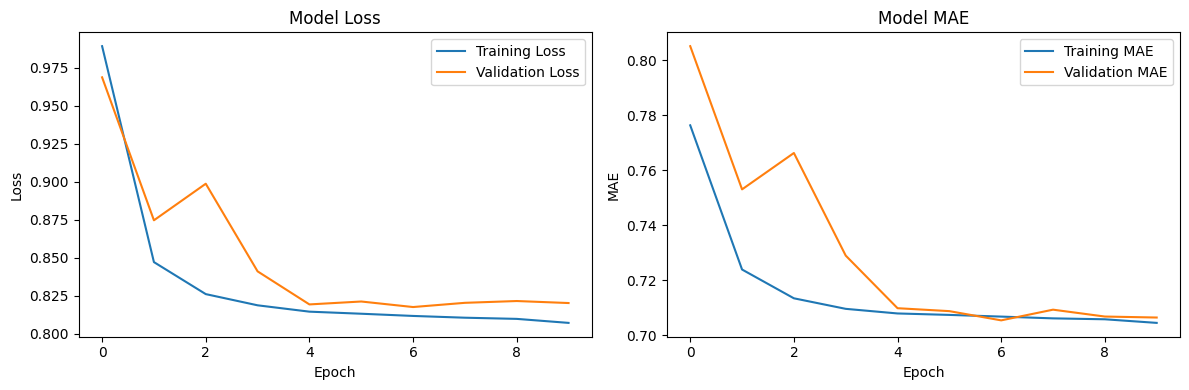

1960/1960 ━━━━━━━━━━━━━━━━━━━━ 2s 815us/step - loss: 0.8787 - mae: 0.7125

Test MAE: 0.7169


In [8]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

def build_recommender(n_users, n_movies, n_factors=50, n_features=50):
    """
    Build a neural network recommender model
    
    Parameters:
    - n_users: number of unique users
    - n_movies: number of unique movies
    - n_factors: embedding size for users and movies
    - n_features: number of genome features (PCA components)
    """
    # Input layers
    user_input = Input(shape=(1,), name='user_input')
    movie_input = Input(shape=(1,), name='movie_input')
    features_input = Input(shape=(n_features,), name='features_input')
    
    # Embedding layers
    user_embedding = Embedding(
        n_users, n_factors, 
        embeddings_regularizer=l2(1e-6),
        name='user_embedding'
    )(user_input)
    movie_embedding = Embedding(
        n_movies, n_factors,
        embeddings_regularizer=l2(1e-6),
        name='movie_embedding'
    )(movie_input)
    
    # Flatten embeddings
    user_vec = Flatten(name='user_flatten')(user_embedding)
    movie_vec = Flatten(name='movie_flatten')(movie_embedding)
    
    # Concatenate all features
    concat = Concatenate(name='concat')([
        user_vec,
        movie_vec,
        features_input
    ])
    
    # Dense layers
    dense1 = Dense(256, activation='relu', name='dense1')(concat)
    dropout1 = Dropout(0.3, name='dropout1')(dense1)
    dense2 = Dense(128, activation='relu', name='dense2')(dropout1)
    dropout2 = Dropout(0.2, name='dropout2')(dense2)
    dense3 = Dense(64, activation='relu', name='dense3')(dropout2)
    
    # Output layer
    output = Dense(1, activation='linear', name='rating')(dense3)
    
    # Create model
    model = Model(
        inputs=[user_input, movie_input, features_input],
        outputs=output
    )
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    
    return model

# Prepare data for the model
def prepare_model_inputs(X_data):
    """
    Prepare inputs in the format expected by the model
    """
    return [
        X_data['userId'].clip(0, processed_data['n_users'] - 1).values,  # Ensure user IDs are within valid range
        X_data['movieId'].clip(0, processed_data['n_movies'] - 1).values,  # Ensure movie IDs are within valid range
        X_data[processed_data['feature_columns']].values
    ]

# Create and train the model
model = build_recommender(
    n_users=processed_data['n_users'],
    n_movies=processed_data['n_movies'],
    n_features=len(processed_data['feature_columns'])
)

# Print model summary
model.summary()

# Train the model
history = model.fit(
    prepare_model_inputs(processed_data['X_train']),
    processed_data['y_train'],
    validation_data=(
        prepare_model_inputs(processed_data['X_val']),
        processed_data['y_val']
    ),
    epochs=10,
    batch_size=512,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=2
        )
    ]
)

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate on test set
test_loss, test_mae = model.evaluate(
    prepare_model_inputs(processed_data['X_test_warm']),
    processed_data['y_test_warm'],
    verbose=1
)

print(f"\nTest MAE: {test_mae:.4f}")

In [9]:
import numpy as np
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix

def prepare_matrix_factorization_data(smaller_dataset, n_factors=50):
    """
    Prepare sparse rating matrix for matrix factorization
    """
    ratings = smaller_dataset['ratings']
    
    # Create user-movie sparse matrix
    user_lookup = {id_: i for i, id_ in enumerate(ratings['userId'].unique())}
    movie_lookup = {id_: i for i, id_ in enumerate(ratings['movieId'].unique())}
    
    # Convert to matrix indices
    row = [user_lookup[i] for i in ratings['userId']]
    col = [movie_lookup[i] for i in ratings['movieId']]
    data = ratings['rating'].values
    
    # Create sparse matrix
    rating_matrix = csr_matrix(
        (data, (row, col)), 
        shape=(len(user_lookup), len(movie_lookup))
    )
    
    print("Rating matrix shape:", rating_matrix.shape)
    print("Sparsity: {:.2%}".format(1 - rating_matrix.nnz/(rating_matrix.shape[0]*rating_matrix.shape[1])))
    
    return rating_matrix, user_lookup, movie_lookup

def simple_svd(rating_matrix, n_factors=50):
    """
    Simple SVD implementation
    """
    # Fit SVD
    svd = TruncatedSVD(n_components=n_factors)
    user_factors = svd.fit_transform(rating_matrix)
    item_factors = svd.components_.T
    
    print("\nExplained variance ratio: {:.2%}".format(svd.explained_variance_ratio_.sum()))
    
    return user_factors, item_factors, svd

def predict_ratings(user_factors, item_factors, user_idx, movie_idx):
    """
    Predict ratings using matrix factorization
    """
    return np.dot(user_factors[user_idx], item_factors[movie_idx])

# Prepare data
rating_matrix, user_lookup, movie_lookup = prepare_matrix_factorization_data(smaller_dataset)

# Split into train/val/test
# Note: Using same temporal split logic as before
train_idx = int(rating_matrix.shape[0] * 0.8)
val_idx = int(rating_matrix.shape[0] * 0.9)

train_matrix = rating_matrix[:train_idx]
val_matrix = rating_matrix[train_idx:val_idx]
test_matrix = rating_matrix[val_idx:]

# Fit SVD
user_factors, item_factors, svd = simple_svd(train_matrix)

# Evaluate
def evaluate_predictions(matrix, user_factors, item_factors):
    """
    Calculate MAE for predictions
    """
    rows, cols = matrix.nonzero()
    actual = matrix[rows, cols].A.ravel()
    predicted = np.array([
        predict_ratings(user_factors, item_factors, r, c)
        for r, c in zip(rows, cols)
    ])
    
    mae = np.mean(np.abs(actual - predicted))
    return mae

train_mae = evaluate_predictions(train_matrix, user_factors, item_factors)
val_mae = evaluate_predictions(val_matrix, user_factors, item_factors)
test_mae = evaluate_predictions(test_matrix, user_factors, item_factors)

print("\nResults:")
print(f"Train MAE: {train_mae:.4f}")
print(f"Val MAE: {val_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}")

# Optional: Neural Matrix Factorization
import tensorflow as tf

def build_neural_mf(n_users, n_movies, n_factors=50):
    """
    Neural Matrix Factorization model
    """
    # Input layers
    user_input = Input(shape=(1,))
    movie_input = Input(shape=(1,))
    
    # MF Embeddings
    user_mf = Embedding(n_users, n_factors, name='user_mf')(user_input)
    movie_mf = Embedding(n_movies, n_factors, name='movie_mf')(movie_input)
    
    # MLP Embeddings
    user_mlp = Embedding(n_users, n_factors, name='user_mlp')(user_input)
    movie_mlp = Embedding(n_movies, n_factors, name='movie_mlp')(movie_input)
    
    # MF path
    mf_user_latent = Flatten()(user_mf)
    mf_movie_latent = Flatten()(movie_mf)
    mf_vector = Multiply()([mf_user_latent, mf_movie_latent])
    
    # MLP path
    mlp_user_latent = Flatten()(user_mlp)
    mlp_movie_latent = Flatten()(movie_mlp)
    mlp_vector = Concatenate()([mlp_user_latent, mlp_movie_latent])
    
    mlp_vector = Dense(128, activation='relu')(mlp_vector)
    mlp_vector = Dropout(0.2)(mlp_vector)
    mlp_vector = Dense(64, activation='relu')(mlp_vector)
    
    # Combine MF and MLP
    predict_vector = Concatenate()([mf_vector, mlp_vector])
    prediction = Dense(1)(predict_vector)
    
    model = Model(inputs=[user_input, movie_input], outputs=prediction)
    model.compile(optimizer=Adam(0.001), loss='mse', metrics=['mae'])
    
    return model

Rating matrix shape: (1000, 1000)
Sparsity: 37.29%

Explained variance ratio: 52.28%

Results:
Train MAE: 0.8500
Val MAE: 1.5871
Test MAE: 1.6120
